In [35]:
# Import modues
# -*- encoding: utf-8 -*-
import numpy as np
import matplotlib as mpl
from matplotlib import rc
import math
import pandas as pd
import os
import itertools
from scipy import stats
from scipy import ndimage
import seaborn as sns

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

from skimage import measure
from scipy import ndimage
from scipy import misc

from scipy.stats.stats import pearsonr, spearmanr
from collections import  Counter

# from pandas import ExcelWriter
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.stats.api as sm
from sklearn import cross_validation, datasets, linear_model, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import cross_validation, datasets, grid_search, linear_model, metrics
from sklearn.metrics import classification_report

from scipy.optimize import curve_fit
from scipy import signal

from sklearn import random_projection
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans

sns.set_style("whitegrid")
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette('Accent')

rc('font', family='Arial', size=14)  # change font for russian

rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)
mpl.rcParams.update({'font.size': 14})

% matplotlib inline
print 'Import Ready'

Import Ready


# Spectrum parameters

In [12]:
markers = ['o','s','d','v','h','>','<','*','^','+']
markers_line = ['-o','-s','-d','-v', '-h', '->','-<', '-*']

cmap = plt.get_cmap('Accent')
colors = [cmap(i) for i in np.linspace(0., 1., 8)] * 2

In [13]:
# Function for spectra features
def smooth (spec_i, params, type_smooth):
    # type 1 - average filter, type 2 - SavGol, type 3 - FFT
    '''
    Function for smoothing spectra. Return smooth spectra as np.array of intencity (np.array).
    Parameters: 
        spectra (list of intence)
        parameters of smooth (optimizing): 
            type 1: medians - [window (full size, int)]
            type 2: average - [window (full size, int)]
            type 3: SavGol - [polinom order (int), windows (full size, odd, int)]
            type 4: Discret Furie - [min frequence (float [0, 2])]
        type smooth (see above)
    '''
    spec_i = np.array(spec_i)
    spec_tranc = []
    if type_smooth == 0:
        # median filter w - full window size
        window = params[0]
        spec_i = np.array(spec_i)
        for i in xrange(len(spec_i)):
            d = None 
            if i < window:
                d = np.median(spec_i[0:i+window])
            elif i + window > len(spec_i):
                d = np.median(spec_i[i-window:])
            else:
                d = np.median(spec_i[int(i-window/2):int(i+window/2)])
            spec_tranc.append(d)
    elif type_smooth == 1:
        # average filter w - full window size
        window = params[0]
        spec_i = np.array(spec_i)
        for i in xrange(len(spec_i)):
            d = None
            if i < window:
                d = np.average(spec_i[0:i+window])
            elif i + window > len(spec_i):
                d = np.average(spec_i[i-window:])
            else:
                d = np.average(spec_i[int(i-window/2):int(i+window/2)])
            spec_tranc.append(d)
    elif type_smooth == 2:
        # Sav-Gol filter
        deriv = 0
        rate = 1
        order = params[0]
        window_size = params[1]  # full size
        if window_size % 2 != 1 or window_size < 1:
            print 'window_size size must be a positive odd number'
            return
        if window_size < order + 2:
            print 'window_size is too small for the polynomials order'
            return
        order_range = xrange(order+1)
        half_window = (window_size - 1) // 2
        b = np.mat([[k**i for i in order_range] for k in xrange(- half_window, half_window + 1)])
        m = np.linalg.pinv(b).A[deriv] * rate**deriv * math.factorial(deriv)

        firstvals = spec_i[0] - np.abs(spec_i[1:half_window+1][::-1] - spec_i[0])
        
        lastvals = spec_i[-1] + np.abs(spec_i[-half_window-1:-1][::-1] - spec_i[-1])
        spec_i = np.concatenate((firstvals, spec_i, lastvals))
        spec_tranc = np.convolve(m[::-1], spec_i, mode='valid')

        lendelta = len(spec_tranc) - len(spec_i)
        if lendelta > 0:
            print 'lendelta: ', lendelta
            spec_tranc = spec_tranc[lendelta // 2:]
    else:
        # Calculate furie-conversion os spec
        fft_res = np.fft.fft(spec_i)
        u_crit = params[0]
        n = float(len(fft_res))  # number of channels
        filtered = map(lambda x: 0 if (x / n > u_crit) else fft_res[x], xrange(len(fft_res)))  # old: x > 2+2j
        spec_tranc = map(lambda x: x.real, np.fft.ifft(filtered))
    return np.array(spec_tranc)


# Autofind peacks and base line
def calc_h(i, w, v):
    '''
    Calulate h parameters for 'zero-filter' algorithm. rturn h value (float).
    Parameters:
        i - channel value [0, 4095] (int)
        w - windows (even, int)
        v - windows shift (int)
    '''
    h = None
    if (-v - w / 2) <= i < -w / 2:
        h = -0.5 / v
    elif -0.5*w <= i <= 0.5*w:
        h = 1. / w
    elif 0.5*w < i <= (0.5*w+v):
        h = - 0.5 / v
    else:
        print 'Not good: ', i
    if h == 0: print 'WTF'
    return h


def zero_area(spec, params, type_alg):
    # type_alg = 1 - classical zero-area algorithm, 2, 3 - my algo as float average and 2nd polinom
    '''
    Function for 'zero-area'. Return mask of base line as np.array of baseline intence (np.array)
    Parameters: 
        spectra (list of intence)
        parameters (optimizing): 
            type 1: classical - [window (even, int), window_shift (int)]
            type 2: my as average - [window (int)] - work bad
            type 3: my as parabola - [windows (int)] - work bad
        type smooth (see above)
    '''
    spec_transform = []
    spec = np.array(spec)
    if type_alg == 1:
        w = params[0]
        v = params[1]
        if w % 2 != 0: 
            print 'w mast be even'  # четное
            return
        for i in xrange(len(spec)):
            i = int(i)
            d = 0
            p1 = -v-0.5*w
            p2 = +v+0.5*w
            j = int(p1)
            if i + p1 < 0:
                while j != p2:
                    if i + j < 0:
                        d += calc_h(j, w, v) * spec[0]
                    else:
                        d += calc_h(j, w, v) * spec[int(i+j)]
                    j+=1
            elif i + p2 > len(spec):
                while j != p2:
                    if i + j >= len(spec):
                        d += calc_h(j, w, v) * spec[-1]
                    else:
                        d += calc_h(j, w, v) * spec[int(i+j)]
                    j+=1
            else:
                while j != p2:
                    d += calc_h(j, w, v) * spec[int(i+j)]
                    j+=1
            spec_transform.append(d)
    elif type_alg == 2:
        # Can write the same algo for smoothind filters type 0-2
        chanel = xrange(len(spec))
        w = params[0]  # windows full-lenght
        spec_transform = range(len(spec))
        num_w = int(len(spec) / w)  # numbers of subspec for find peaks
        is_peak_up = [0] * num_w
        is_peak_out = [0] * num_w
        spec_parts = []
        # write cond for peak up and down
        for i in xrange(num_w):
            start_i = w * i
            stop_i = w * (i + 1)
            if stop_i > len(spec): stop_i = len(spec)
            spec_i = np.array(spec[start_i: stop_i])
            spec_parts.append(spec_i)
            aver_i = np.average(spec_i)  # may be use median? - нет, т.к. медиана хуже работает с шумомы
            cond_i = spec_i > aver_i
            if np.sum(cond_i) > w / 2:  # cond for peak
                if np.sum(cond_i[:w/2]) > np.sum(cond_i[w/2:]):
                    is_peak_out[i] = 1
                else:
                    is_peak_up[i] = 1
        for i in xrange(num_w-3):
            d = is_peak_up[i]
            if d and np.sum(is_peak_out[i:i+3]):
                for j in xrange(len(spec_parts[i])):
                    spec_transform[i+j] = 0
            else:
                for j in xrange(len(spec_parts[i])):
                    spec_transform[i+j] = spec_parts[i][j]
        spec_transform.append([0 for x in xrange((num_w-3)*w)])
    elif type_alg == 3:
        deriv = 0
        rate = 1
        order = 4
        window_size = params[0]  # full size
        if window_size < order + 2:
            print 'window_size is too small for the polynomials order'
            return
        
        chanel = xrange(len(spec))
        spec_transform = range(len(spec))
        
        num_w = int(len(spec) / window_size)  # numbers of subspec for find peaks
        spec_parts = [spec[x*window_size:(x+1)*window_size] for x in xrange(num_w-1)]
        for i in xrange(len(spec_parts)):
            # aprox point as 2nd order polinom and calculate a and R2
            raw_spec = spec_parts[i]
            coef, covar, R2 = approx_poly(xrange(len(raw_spec)), raw_spec, 2)
            a = coef[0]
            if a < 0 and R2 > 0.7:
                # is peak
                for j in xrange(len(spec_parts[i])):
                    spec_transform[i+j] = 0
            else:
                for j in xrange(len(spec_parts[i])):
                    spec_transform[i+j] = spec_parts[i][j]
    return np.array(spec_transform[:4095])


def is_baseline(spec_tr, floor = -1):
    # return True/false mask for baseline
    '''
    Function for baseline mask. Return mask as np.array of boolen (np.array)
    Parameters: 
        spectra of baseline (list of intence)
        parameters (optimizing): 
            medians - [flag of maximum base intence (int or float)]
    '''
    spec_tr = np.abs(spec_tr)
    flag = floor
    if floor < 0:
        flag = np.average(spec_tr)
    spec_res = spec_tr < flag
    for i in xrange(10,len(spec_res)-10):
        if spec_res[i] and np.sum(spec_res[i-10:i+10]) < 10:
            spec_res[i] = False
    return spec_res


# Calculate finish parameters
def approx_poly(list_x, list_y, order):
    # calculate coef for polinom approximation [A, B], y = Ax + B return highest power first
    '''
    Function for approximate points as order poinom. Return approximate coeffisients? covariation matrix  and R2 (list)
    Parameters: 
        list of x points
        list of y points
        order of polinom
    '''
    poly_coeff = np.polyfit(list_x, list_y, order, cov=True)
    R2 = None
    # r-squared for 1 order  TODO: add Matius coefficient
    if (order - 1.0) < 1.5:  # use 0.5 for 1st order polinom
        p = np.poly1d(poly_coeff[0])
        # fit values, and mean
        yhat = p(list_x)                         # or [p(z) for z in x]
        ybar = np.sum(list_y)/len(list_y)          # or sum(y)/len(y)
        ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
        sstot = np.sum((list_y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
        R2 = ssreg / sstot
        R2 = round(float(R2), 5)
    return poly_coeff[0], poly_coeff[1], R2


def cur_poly_value(x, coef):
    # return y for x and coef of polinom, coef highest power first
    '''
    Function for calculate point with polinoms coefficients. Return value of polinom (float).
    Parameters: 
        point (int)
        coefficient (highest pover first, list)
    '''
    res = 0.0
    cur_x_dg = 1.0
    for i in xrange(1, len(coef)+1):
        res += cur_x_dg * coef[-i]
        cur_x_dg *= x
    return res


def calc_all_area(spec_i):
    # return area of spectra
    '''
    Function for calculate area of baseline. Return data (float).
    Parameters: 
        baseline spectra of intencity (list)
    '''
    return np.sum(spec_i)


def calc_baseline(spec_i, baseline_mask):
    # return Imax ans S of background
    '''
    Function for approximate baseline as 5th order poinom. Return approximate baseline as array of intencity (np.array).
    Parameters: 
        spectra (list of intence)
        baseline mask (list of boolen)
    '''
    spec_i = np.array(spec_i)
    x = np.array([x for x in xrange(len(spec_i))])
    poly_coef = approx_poly(x[baseline_mask], spec_i[baseline_mask], 5)[0]
    approx_baseline = []
    for i in x:
        approx_baseline.append(cur_poly_value(i, poly_coef))
    approx_baseline = np.array(approx_baseline)
    return approx_baseline


def calc_peacs(spec_i, base_fit, baseline_mask, parameters = None, type_calc=2, energy = 0.2, a0=None, a1=None):
    # return i_max, S and channel of peack
    '''
    Function for calculate peak data. 
    Return:
        intencity of peaks (list)
        cannels of peaks (list)
        gauss intencity of each peaks (list)
        gayss squares of each peaks (list)
        intencity of fitting base line (list)
    Parameters: 
        spectra (list of intence)
        baseline (list of intence)
        baseline mask (list of boolen)
        parameters (for optimisation):
            type 1 (derivative): [iteration for smooth of diff spectra [0, 10], treshold of peak mask [2,50]] 
            type 2 (zero-area base): [iteration of smooth (int)]
        type (see above)
        energy of close peak (treshold parameters, float 0.2)
        a0, a1 - channel to energy parameters (float)
    '''
    spec_i = np.array(spec_i)
    max_delta_chan = None
    if a0 is not None and a1 is not None:
        max_delta_chan = (energy - a0) / a1  # for close peaks
    else:
        max_delta_chan = (energy - spe_df['a0'][0]) / spe_df['a1'][0]  # for close peaks
    
    if type_calc == 1:
        # derivative type - for all spectra
        itera = parameters[0]  # 
        der_threshold = parameters[1]  # 10 for work - oprimize
        spec_new = np.diff(spec_i, 2)
        while itera > 0:
            spec_new = smooth(spec_new, params=[3, 11], type_smooth=2)  # Sav-Gol
            itera -= 1
        der = np.array(spec_new)
        peak_mask = der < der_threshold  # peak search
        i_all = []
        channel_all = []
        delta_peak = 0
        for i in xrange(len(peak_mask)-1):
            # search peaks channel
            if peak_mask[i] and peak_mask[i+1]:  # TODO: set threshold longer then i+1 ?
                # if peak prolong
                delta_peak += 1
            elif peak_mask[i]:
                # end peak
                if delta_peak > 0:
                    i_max = np.max(spec_i[i-delta_peak:i])  # max intence
                    c = np.where(spec_i[i-delta_peak:i] == i_max)[0][0]  # channel of max intence
                    i_max = np.average(spec_i[i-delta_peak+c-3:i-delta_peak+c+3])  # calculate average of i_max
                    i_all.append(i_max)
                else:
                    pass
            else:
                # no peak
                delta = 0
        # calculate square of peak and (I - base line)
        i_all = np.array(i_all)
        gauss_i, gauss_s, base_i = gauss_peaks(i_all, channel_all, base_fit, spec_i)
    elif type_calc == 2:
        w0 = 3  # parameters[0]  # SG polinom order
        w1 = 11  # parameters[1]  # SG window size
        itera = parameters[0]  # numbers of iteration - optimize, 2
        x = np.array(xrange(len(spec_i)))
        x_peak = x[~baseline_mask]  # mask for peaks
        
        spec_new = []
        for i in xrange(len(spec_i)):
            # for new 'spec' with peak only
            if i in x_peak:
                spec_new.append(spec_i[i])
            else:
                spec_new.append(0)
        while itera > 0:
            spec_new = smooth(spec_new, params=[w0, w1], type_smooth=2)  # Sav-Gol
            itera -= 1
        channel_all = (np.diff(np.sign(np.diff(spec_new))) < 0).nonzero()[0] # + 1  # local max channel
        
        spec_new = np.array(spec_new)
        i_all = spec_new[channel_all]
        i_all = np.array(i_all)
        channel_all = channel_all[i_all > 1.]
        i_all = i_all[i_all > 1.]
        gauss_i, gauss_s, base_i =  gauss_peaks(i_all, channel_all, base_fit, spec_i)
    return i_all, channel_all, gauss_i, gauss_s, base_i


def gaus(x,a,x0,sigma):
    # for gaussian fit
    '''
    Function for gaussian curve. Return gauss data (int or np.array)
    Parameters: 
        x point 
        aplitude
        senter of peak
        std of peak
    '''
    return a * np.exp(-(x - x0)*(x - x0) / (2 * sigma*sigma))


def gauss_peaks(i_all, channel_all, base_fit, spec_i):
    # calculate Gauss S and I of peaks
    '''
    Function for gaussian approximation of peaks. 
    Return:
        intens of peaks (np.array)
        squares of peaks (np.array)
        intence of base line (np.array)
    Parameters: 
        intence of peaks (list) 
        channels of peaks (list)
        intence of fit baseline (list)
        intence of raw spectra (list)
    '''
    base_i = []
    gauss_s = []
    gauss_i = []
    for i in xrange(len(channel_all)):
        c_middle = channel_all[i]
        base_i.append(np.average(base_fit[c_middle]))
        g_h = 0
        g_s = 0
        w = 15
        y = np.array(spec_i[c_middle-w:c_middle+w])  # gauss fit of points
        x = np.array(xrange(len(y)))
        if y.shape is not () and x.shape is not ():
        # correction for weighted arithmetic mean
            mean = np.sum(x * y) / np.sum(y)
            sigma = np.sqrt(np.sum(y * (x - mean)**2) / np.sum(y))
            try:
                popt,pcov = curve_fit(gaus, x, y, p0=[max(y), mean, sigma])
                y_fit = gaus(x, *popt)
                g_h = np.max(y_fit)
                g_s = g_h * (2 * np.pi) ** 0.5 * popt[-1]  # gauss square
                w += 2
            except RuntimeError as var:
                g_h = 0
                g_s = 0
            except ValueError as var:
                print var
                print x, y
                g_h = 0
                g_s = 0
        else:
            g_h = 0
            g_s = 0
        gauss_i.append(g_h)
        gauss_s.append(g_s)

            
    return np.array(gauss_i), np.array(gauss_s), np.array(base_i)

In [3]:
# load spec data
def dir_name(_):
    _ = _[0].split('\\')
    if len(_) > 1: return 'specs/' + _[1]

dirs = ['specs/' + x for x in list(os.walk('specs'))[0][1]]

dict_obj_spe = {}

directs = dirs
shifr = dict(zip(range(len(directs)), directs))
counter = 0
for dir_name in directs:
    if dir_name:
        print 'Files in directory: ', dir_name, len(os.listdir(dir_name))
        data_num = xrange(len(os.listdir(dir_name)))
        n = dir_name.split('/')[1]
        n = n.split('_')
        
        ftype = n[0].lower()
        mark = n[1]
        fraction =n[2]
        kd = n[3]  # binary yes/no
        
        if len(kd.split('.')) > 1:
            kd = kd.split('.')[1]  # float or none - undefine
        
        for i in xrange(len(os.listdir(dir_name))):
            dict_obj_spe[counter] = {}
            i = os.listdir(dir_name)[i]
            name =  str(i)
            if '.spe' in i:
                spec_file = open(dir_name + '/' + i)
                
                spec_num = i.split('_')[-1][0]  # select one number
                if spec_num in ['1', '2']:
                    _ = i.split('_')[-1][1]
                    if _ not in ['(', '.']:
                        spec_num += _
                if ftype == 'npss.zn':
                    spec_num = i.split('_')[-2] + '_' + spec_num
                if ftype == 'an':
                    spec_num = '_'.join(i.split('_')[1:4])
                    spec_num = spec_num[:-4]
                if spec_num in ['(','.','00','k','n']:
                    print i, ' ', spec_num, ' ', ftype
                lines = spec_file.readlines()
                spec_file.close()

                # properties
                exposition = None
                voltage = None
                anod_current = None
                atmo = None
                list_e = []
                list_i = []

                try:
                    exposition = int(lines[3])
                    voltage = int(lines[6])
                    anod_current = int(lines[7])
                    atmo = int(lines[17])
                except ValueError as var:
                    print ('ERROR: ', var)
                a0 = float(lines[19])
                a1 = float(lines[20])
                a2 = float(lines[21])

                lines_spec = tuple(lines[32:])

                c = 0
                for ind in lines_spec:
                    e = a0 + a1*c + a2*c*c
                    list_e.append(e)
                    list_i.append(int(ind))
                    c += 1

                dict_obj_spe[counter]['exposition'] = exposition
                dict_obj_spe[counter]['voltage'] = voltage
                dict_obj_spe[counter]['current'] = anod_current 
                dict_obj_spe[counter]['atmo'] = atmo
                dict_obj_spe[counter]['ftype'] = ftype
                dict_obj_spe[counter]['mark'] = mark
                dict_obj_spe[counter]['spec_num'] = spec_num
                dict_obj_spe[counter]['fraction'] = fraction
                dict_obj_spe[counter]['kd'] = kd
                dict_obj_spe[counter]['a0'] = a0
                dict_obj_spe[counter]['a1'] = a1
                dict_obj_spe[counter]['a2'] = a2
                dict_obj_spe[counter]['energy'] = list_e
                dict_obj_spe[counter]['intence'] = list_i
                counter += 1
print ('Done')

Files in directory:  specs/NPKS_4.30.15.16_rawgrain_kd.None 10
Files in directory:  specs/NPKS_4.30.15.16_grain_kd.None 24
Files in directory:  specs/NPKS_4.30.15.16_100_kd.None 29
Files in directory:  specs/NPKS_4.30.15.16_500_kd.None 26
Files in directory:  specs/NPKS_4.30.15.16_500.dry_kd.None 15
Files in directory:  specs/NPKS_4.30.15.16_100.dry_kd.None 14
Done


In [28]:
# Create df
spe_df = pd.DataFrame.from_dict(dict_obj_spe, orient='index')

## Оптимизация выделения информации из спектров - работаем с гранулами как наиболее неоднородной информацией

In [5]:
# smoothing spectra

test_df = spe_df[spe_df.fraction == 'grain']
ftype_all = Counter(test_df.mark)
print ftype_all
aver_spec_type = {}

smooth_type = {
    0:xrange(2,23,5),
    1:xrange(2,23,5),
    2:[xrange(2,6), (7,9,15,21)],
    3:np.arange(1, 150, 20) / 100.
}

data_smooth1 = {}

for ftype in ftype_all.keys():
    # minimaise delta with average spectra for each type
    test_df2 = test_df[test_df.mark == ftype]
    spec_all = test_df2.intence
    aver_spec = np.mean(np.array([np.array(x) for x in spec_all]), axis=0)
    aver_spec_type[ftype] = aver_spec
    data_smooth1[ftype] = {}
    
    # smooth
    for t in smooth_type.keys():
        print ftype, 'smooth type: ', t,
        data_smooth1[ftype][t] = {}
        if t != 2:
            data_smooth1[ftype][t]['no'] = {} 
            for p in smooth_type[t]:
                s = []
                for spec_i in test_df2.intence:
                    s.append(np.array(smooth(spec_i, [p], type_smooth=t)))
                now_mean = np.mean(np.array([np.array(x) for x in s]), axis=0)
                delta = (aver_spec - now_mean) / np.average(aver_spec) * 100.
                data_smooth1[ftype][t]['no'][p] = np.mean(delta[:2500])
        else:
            data_smooth1[ftype][t] = {}
            for p in smooth_type[t][0]:
                data_smooth1[ftype][t][p] = {}
                for p2 in smooth_type[t][1]:
                    s = []
                    for spec_i in test_df2.intence:
                        s.append(np.array(smooth(spec_i, [p, p2], type_smooth=t)))
                    now_mean = np.mean(np.array([np.array(x) for x in s]), axis=0)
                    delta = (aver_spec - now_mean)/ np.average(aver_spec) * 100.
                    data_smooth1[ftype][t][p][p2] = np.mean(delta[:2500])
        print 'done'
print 'All Done'

Counter({'4.30.15.16': 24})
4.30.15.16 smooth type:  0 done
4.30.15.16 smooth type:  1 done
4.30.15.16 smooth type:  2 done
4.30.15.16 smooth type:  3 done
All Done


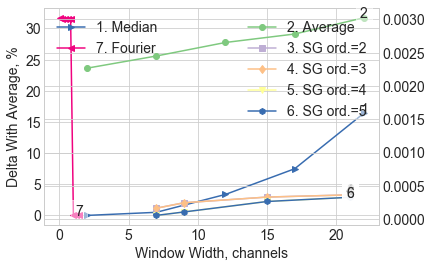

In [44]:
# aver_spec_type - include average spec for first key
mpl.rcParams.update({'font.size': 14})
for f in data_smooth1:
    # Create structure for plot
    counter = 1
    metrik_data=[]
    x_data = []
    metrik_name = []
    for a in data_smooth1[f]:
        if a in [0,1,3]:
            temp_d = []
            temp_x = []
            for p2 in data_smooth1[f][a]['no']:
                temp_d.append(data_smooth1[f][a]['no'][p2])
                temp_x.append(p2)
            temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
            metrik_data.append(temp_d)
            x_data.append(temp_x)
            if a == 1:
                metrik_name.append(str(counter) + u'. Average')
            elif a == 0:
                metrik_name.append(str(counter) + u'. Median')
            else:
                metrik_name.append(str(counter) + u'. Fourier')
            counter += 1
        else:
            for p1 in data_smooth1[f][a]:
                temp_d = []
                temp_x = []
                for p2 in data_smooth1[f][a][p1]:
                    temp_d.append(data_smooth1[f][a][p1][p2])
                    temp_x.append(p2)
                temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
                metrik_data.append(temp_d)
                x_data.append(temp_x)
                metrik_name.append(str(counter) + u'. SG ord.='+str(p1))
                counter += 1

    # create structure for two axis
    metrik_data1, metrik_data2 = [], []
    x_data1, x_data2 = [], []
    metrik_name1, metrik_name2 = [], []
    for i in xrange(len(metrik_data)):
        if u'SG' in metrik_name[i] or u'. Average' in metrik_name[i]:
            metrik_data1.append(metrik_data[i])
            x_data1.append(x_data[i])
            metrik_name1.append(metrik_name[i])
        else:
            metrik_data2.append(metrik_data[i])
            x_data2.append(x_data[i])
            metrik_name2.append(metrik_name[i])

    c=0
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in xrange(len(metrik_data1)):
        y = metrik_data1[i]
        x = x_data1[i]
        ax2.plot(x, y, markers_line[c], label=metrik_name1[i], c=colors[i])
        ax2.text(x[-1], y[-1], metrik_name1[i].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
        c+=1

    for j in xrange(len(metrik_data2)):
        y = metrik_data2[j]
        x = x_data2[j]
        ax1.plot(x, y, markers_line[c], label=metrik_name2[j], c=colors[j+len(metrik_name1)-1])
        ax1.text(x[-1], y[-1], metrik_name2[j].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
        c+=1

    ax1.set_xlabel(u'Window Width, channels')
    ax1.set_ylabel(u'Delta With Average, %')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.draw()
    plt.savefig(f+' spec_smooth_aver_eng.png', dpi=300)
    plt.show()

In [15]:
# std-optimization

test_df = spe_df[spe_df.fraction == 'grain']
ftype_all = Counter(test_df.ftype)
print ftype_all
aver_spec_type = {}

smooth_type = {
    0:xrange(2,23,5),
    1:xrange(2,23,5),
    2:[xrange(2,6), (7,9,15,21)],
    3:np.arange(1, 150, 20) / 100.
}

data_smooth2 = {}

for ftype in ftype_all.keys():
    # minimaise delta with average spectra for each type
    test_df2 = test_df[test_df.ftype == ftype]
    spec_all = test_df2.intence
    aver_std = np.std(np.array([np.array(x) for x in spec_all]), axis=0)
    aver_spec_type[ftype] = aver_std
    data_smooth2[ftype] = {}
    print np.average(aver_std)
    
    # smooth
    for t in smooth_type.keys():
        print ftype, 'smooth type: ', t,
        data_smooth2[ftype][t] = {}
        if t != 2:
            data_smooth2[ftype][t]['no'] = {} 
            for p in smooth_type[t]:
                s = []
                for spec_i in test_df2.intence:
                    s.append(np.array(smooth(spec_i, [p], type_smooth=t)))
                std_spec_i = np.std(s, axis=0)
                data_smooth2[ftype][t]['no'][p] = np.average(std_spec_i, axis=0) / np.average(aver_std, axis=0) * 100.
        else:
            data_smooth2[ftype][t] = {}
            for p in smooth_type[t][0]:
                data_smooth2[ftype][t][p] = {}
                for p2 in smooth_type[t][1]:
                    s = []
                    for spec_i in test_df2.intence:
                        s.append(np.array(smooth(spec_i, [p,p2], type_smooth=t)))
                    data_smooth2[ftype][t][p][p2] = np.average(np.std(s, axis=0),axis=0) / np.average(aver_std, axis=0) * 100.
        print 'done'
print 'All Done'

Counter({'npks': 24})
19.621613426299703
npks smooth type:  0 done
npks smooth type:  1 done
npks smooth type:  2 done
npks smooth type:  3 done
All Done


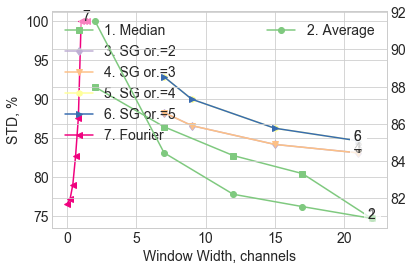

In [43]:
mpl.rcParams.update({'font.size': 14})

for f in data_smooth2:
    # Create structure for plot
    counter = 1
    metrik_data=[]
    x_data = []
    metrik_name = []
    for a in data_smooth2[f]:
        if a in [0,1,3]:
            temp_d = []
            temp_x = []
            for p2 in data_smooth2[f][a]['no']:
                temp_d.append(data_smooth2[f][a]['no'][p2])
                temp_x.append(p2)
            temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
            metrik_data.append(temp_d)
            x_data.append(temp_x)
            if a == 1:
                metrik_name.append(str(counter) + u'. Average')
            elif a == 0:
                metrik_name.append(str(counter) + u'. Median')
            else:
                metrik_name.append(str(counter) + u'. Fourier')
            counter += 1
        else:
            for p1 in data_smooth2[f][a]:
                temp_d = []
                temp_x = []
                for p2 in data_smooth2[f][a][p1]:
                    temp_d.append(data_smooth2[f][a][p1][p2])
                    temp_x.append(p2)
                temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
                metrik_data.append(temp_d)
                x_data.append(temp_x)
                metrik_name.append(str(counter) + u'. SG or.='+str(p1))
                counter += 1

    # create structure for two axis
    metrik_data1, metrik_data2 = [], []
    x_data1, x_data2 = [], []
    metrik_name1, metrik_name2 = [], []
    for i in xrange(len(metrik_data)):
        if u'СГ' in metrik_name[i] or u'. Average' in metrik_name[i]:
            metrik_data1.append(metrik_data[i])
            x_data1.append(x_data[i])
            metrik_name1.append(metrik_name[i])
        else:
            metrik_data2.append(metrik_data[i])
            x_data2.append(x_data[i])
            metrik_name2.append(metrik_name[i])

    c=0
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in xrange(len(metrik_data1)):
        y = metrik_data1[i]
        x = x_data1[i]
        ax2.plot(x, y, markers_line[c], label=metrik_name1[i], c=colors[i])
        ax2.text(x[-1], y[-1], metrik_name1[i].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
        c+=1

    for j in xrange(len(metrik_data2)):
        y = metrik_data2[j]
        x = x_data2[j]
        ax1.plot(x, y, markers_line[c], label=metrik_name2[j], c=colors[j+len(metrik_name1)-1])
        ax1.text(x[-1], y[-1], metrik_name2[j].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
        c+=1

    ax1.set_xlabel(u'Window Width, channels')
    ax1.set_ylabel(u'STD, %')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.draw()
    plt.savefig(f+'_spec_smooth_std_eng.png', dpi=300)
    plt.show()

In [17]:
# max_peak-optimization

# smoothing spectra
test_df = spe_df[spe_df.fraction == 'grain']
ftype_all = Counter(test_df.ftype)
print ftype_all
aver_spec_type = {}

smooth_type = {
    0:xrange(2,23,5),
    1:xrange(2,23,5),
    2:[xrange(2,6), (7,9,15,21)],
    3:np.arange(1, 150, 20) / 100.
}

data_smooth3 = {}

for ftype in ftype_all.keys():
    # minimaise delta with average spectra for each type
    test_df2 = test_df[test_df.ftype == ftype]
    spec_all = test_df2.intence
    aver_spec = np.mean(np.array([np.array(x) for x in spec_all]), axis=0)
    aver_spec_type[ftype] = aver_spec
    data_smooth3[ftype] = {}
    
    # smooth
    for t in smooth_type.keys():
        print ftype, 'smooth type: ', t,
        data_smooth3[ftype][t] = {}
        if t != 2:
            data_smooth3[ftype][t]['no'] = {} 
            for p in smooth_type[t]:
                s = []
                for spec_i in test_df2.intence:
                    s.append(np.max(smooth(spec_i, [p], type_smooth=t)))
                std_spec_i = np.average(s)
                data_smooth3[ftype][t]['no'][p] = - (std_spec_i - np.max(aver_spec)) / np.max(aver_spec) * 100.
        else:
            data_smooth3[ftype][t] = {}
            for p in smooth_type[t][0]:
                data_smooth3[ftype][t][p] = {}
                for p2 in smooth_type[t][1]:
                    s = []
                    for spec_i in test_df2.intence:
                        s.append(np.max(smooth(spec_i, [p,p2], type_smooth=t)))
                    std_spec_i = np.average(s)
                    data_smooth3[ftype][t][p][p2] = - (std_spec_i - np.max(aver_spec)) / np.max(aver_spec) * 100. 
        print 'done'
print 'All Done'

Counter({'npks': 24})
npks smooth type:  0 done
npks smooth type:  1 done
npks smooth type:  2 done
npks smooth type:  3 done
All Done


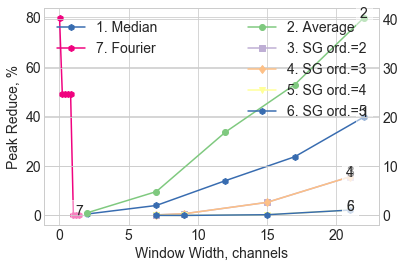

In [42]:
mpl.rcParams.update({'font.size': 14})

for f in data_smooth3:
    # Create structure for plot
    counter = 1
    metrik_data=[]
    x_data = []
    metrik_name = []
    for a in data_smooth3[f]:
        if a in [0,1,3]:
            temp_d = []
            temp_x = []
            for p2 in data_smooth3[f][a]['no']:
                temp_d.append(data_smooth3[f][a]['no'][p2])
                temp_x.append(p2)
            temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
            metrik_data.append(temp_d)
            x_data.append(temp_x)
            if a == 1:
                metrik_name.append(str(counter) + u'. Average')
            elif a == 0:
                metrik_name.append(str(counter) + u'. Median')
            else:
                metrik_name.append(str(counter) + u'. Fourier')
            counter += 1
        else:
            for p1 in data_smooth3[f][a]:
                temp_d = []
                temp_x = []
                for p2 in data_smooth3[f][a][p1]:
                    temp_d.append(data_smooth3[f][a][p1][p2])
                    temp_x.append(p2)
                temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
                metrik_data.append(temp_d)
                x_data.append(temp_x)
                metrik_name.append(str(counter) + u'. SG ord.='+str(p1))
                counter += 1

    # create structure for two axis
    metrik_data1, metrik_data2 = [], []
    x_data1, x_data2 = [], []
    metrik_name1, metrik_name2 = [], []
    for i in xrange(len(metrik_data)):
        if u'SG' in metrik_name[i] or u'. Average' in metrik_name[i]:
            metrik_data1.append(metrik_data[i])
            x_data1.append(x_data[i])
            metrik_name1.append(metrik_name[i])
        else:
            metrik_data2.append(metrik_data[i])
            x_data2.append(x_data[i])
            metrik_name2.append(metrik_name[i])

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in xrange(len(metrik_data1)):
        y = metrik_data1[i]
        x = x_data1[i]
        ax2.plot(x, y, markers_line[i], label=metrik_name1[i], c=colors[i])
        ax2.text(x[-1], y[-1], metrik_name1[i].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    for j in xrange(len(metrik_data2)):
        y = metrik_data2[j]
        x = x_data2[j]
        ax1.plot(x, y, markers_line[i], label=metrik_name2[j], c=colors[j+len(metrik_name1)-1])
        ax1.text(x[-1], y[-1], metrik_name2[j].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
        
    ax1.set_xlabel(u'Window Width, channels')
    ax1.set_ylabel(u'Peak Reduce, %')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.draw()
    plt.savefig(f+'_spec_smooth_max_eng.png', dpi=300)
    plt.show()

In [19]:
# shift max_peak-optimization

# smoothing spectra
test_df = spe_df[spe_df.fraction == 'grain']
ftype_all = Counter(test_df.ftype)
print ftype_all
aver_spec_type = {}

smooth_type = {
    0:xrange(2,23,5),
    1:xrange(2,23,5),
    2:[xrange(2,6), (7,9,15,21)],
    3:np.arange(1, 150, 20) / 100.
}

data_smooth4 = {}

for ftype in ftype_all.keys():
    # minimaise delta with average spectra for each type
    test_df2 = test_df[test_df.ftype == ftype]
    spec_all = test_df2.intence
    aver_spec = np.mean(np.array([np.array(x) for x in spec_all]), axis=0)
    aver_spec_type[ftype] = np.where(aver_spec == np.max(aver_spec))[0][0]
    data_smooth4[ftype] = {}
    
    # smooth
    for t in smooth_type.keys():
        print ftype, 'smooth type: ', t,
        data_smooth4[ftype][t] = {}
        if t != 2:
            data_smooth4[ftype][t]['no'] = {} 
            for p in smooth_type[t]:
                s = []
                for spec_i in test_df2.intence:
                    ss = smooth(spec_i, [p], type_smooth=t)
                    s.append(np.where(ss == np.max(ss))[0][0])
                std_spec_i = (aver_spec_type[ftype] - np.abs(np.average(s)))/ aver_spec_type[ftype] * 100. 
                data_smooth4[ftype][t]['no'][p] = std_spec_i
        else:
            data_smooth4[ftype][t] = {}
            for p in smooth_type[t][0]:
                data_smooth4[ftype][t][p] = {}
                for p2 in smooth_type[t][1]:
                    s = []
                    for spec_i in test_df2.intence:
                        ss = smooth(spec_i, [p,p2], type_smooth=t)
                        s.append(np.where(ss == np.max(ss))[0][0])
                    std_spec_i = (aver_spec_type[ftype] - np.abs(np.average(s)))/ aver_spec_type[ftype] * 100.
                    data_smooth4[ftype][t][p][p2] = std_spec_i
        print 'done'
print 'All Done'

Counter({'npks': 24})
npks smooth type:  0 done
npks smooth type:  1 done
npks smooth type:  2 done
npks smooth type:  3 done
All Done


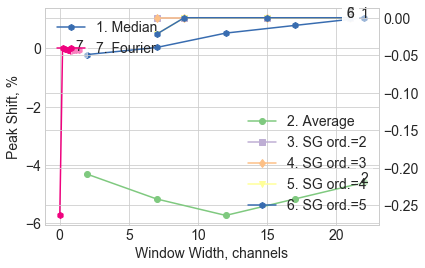

In [41]:
mpl.rcParams.update({'font.size': 14})

for f in data_smooth4:
    # Create structure for plot
    counter = 1
    metrik_data=[]
    x_data = []
    metrik_name = []
    for a in data_smooth4[f]:
        if a in [0,1,3]:
            temp_d = []
            temp_x = []
            for p2 in data_smooth4[f][a]['no']:
                temp_d.append(data_smooth4[f][a]['no'][p2])
                temp_x.append(p2)
            temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
            metrik_data.append(temp_d)
            x_data.append(temp_x)
            if a == 1:
                metrik_name.append(str(counter) + u'. Average')
            elif a == 0:
                metrik_name.append(str(counter) + u'. Median')
            else:
                metrik_name.append(str(counter) + u'. Fourier')
            counter += 1
        else:
            for p1 in data_smooth4[f][a]:
                temp_d = []
                temp_x = []
                for p2 in data_smooth4[f][a][p1]:
                    temp_d.append(data_smooth4[f][a][p1][p2])
                    temp_x.append(p2)
                temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
                metrik_data.append(temp_d)
                x_data.append(temp_x)
                metrik_name.append(str(counter) + u'. SG ord.='+str(p1))
                counter += 1

    # create structure for two axis
    metrik_data1, metrik_data2 = [], []
    x_data1, x_data2 = [], []
    metrik_name1, metrik_name2 = [], []
    for i in xrange(len(metrik_data)):
        if u'SG' in metrik_name[i] or u'. Average' in metrik_name[i]:
            metrik_data1.append(metrik_data[i])
            x_data1.append(x_data[i])
            metrik_name1.append(metrik_name[i])
        else:
            metrik_data2.append(metrik_data[i])
            x_data2.append(x_data[i])
            metrik_name2.append(metrik_name[i])

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in xrange(len(metrik_data1)):
        y = metrik_data1[i]
        x = x_data1[i]
        ax2.plot(x, y, markers_line[i], label=metrik_name1[i], c=colors[i])
        ax2.text(x[-1], y[-1], metrik_name1[i].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    for j in xrange(len(metrik_data2)):
        y = metrik_data2[j]
        x = x_data2[j]
        ax1.plot(x, y, markers_line[i], label=metrik_name2[j], c=colors[j+len(metrik_name1)-1])
        ax1.text(x[-1], y[-1], metrik_name2[j].split('.')[0],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    ax1.set_xlabel(u'Window Width, channels')
    ax1.set_ylabel(u'Peak Shift, %')
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')
    plt.draw()
    plt.savefig(f+'_spec_smooth_shift_eng.png', dpi=300)
    plt.show()

In [21]:
# Find of base line

test_df = spe_df[spe_df.fraction == 'grain']
ftype_all = Counter(test_df.ftype)

base_type = {
    1:[[2,6,10,14,20], xrange(5,21,5)],
    2:xrange(2,40,5),
    3: xrange(10,40,5)  # т.к. Сав-Гол
}

baseline_spec_type = {}
baseline_spec_aver_int = {}
baseline_spec_aver_len = {}
data_base_max = {}
data_base_len = {}

for ftype in ftype_all.keys():
    # minimaise delta with average spectra for each type
    test_df2 = test_df[test_df.ftype == ftype]
    spec_all = test_df2.intence
    all_spec = np.array([np.array(x) for x in spec_all])
    aver_spec = np.mean(all_spec, axis=0)
    baseline_spec_type[ftype] = aver_spec
    baseline_spec_aver_int[ftype] = np.average(aver_spec[aver_spec < np.mean(aver_spec)])
    baseline_spec_aver_len[ftype] = len(aver_spec[aver_spec < np.mean(aver_spec)])
    data_base_max[ftype] = {}
    data_base_len[ftype] = {}
    # find baseline
    for t in base_type.keys():
        print ftype, 'baseline type: ', t, 
        data_base_max[ftype][t] = {}
        data_base_len[ftype][t] = {}
        if t != 1:
            data_base_max[ftype][t]['no'] = {}
            data_base_len[ftype][t]['no'] = {}
            for p in base_type[t]:
                s = []
                len_s = []
                for spec_i in test_df2.intence:
                    ss = zero_area(spec_i, [p], type_alg=t)
                    len_s.append(np.average(np.array(spec_i) - np.array(ss)))  # delta
                    s.append(np.average(ss))  # average
                data_base_max[ftype][t]['no'][p] = np.average(s)
                data_base_len[ftype][t]['no'][p] = np.average(len_s)
        else:
            for p in base_type[t][0]:
                print p,
                data_base_max[ftype][t][p]={}
                data_base_len[ftype][t][p]={}
                for p2 in base_type[t][1]:
                    print ' -', p2,
                    s = []
                    len_s = []
                    for spec_i in test_df2.intence:
                        ss = zero_area(spec_i, [p, p2], type_alg=t)
                        len_s.append(np.average(np.array(spec_i) - np.array(ss)))
                        s.append(np.average(ss))
                    data_base_max[ftype][t][p][p2]=np.average(s)
                    data_base_len[ftype][t][p][p2]=np.average(len_s)
                print ' +'
        print 'done'
print 'All Done'

npks baseline type:  1 2  - 5  - 10  - 15  - 20  +
6  - 5  - 10  - 15  - 20  +
10  - 5  - 10  - 15  - 20  +
14  - 5  - 10  - 15  - 20  +
20  - 5  - 10  - 15  - 20  +
done
npks baseline type:  2 done
npks baseline type:  3

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:248: RuntimeWarning: invalid value encountered in double_scalars


 done
All Done


npks


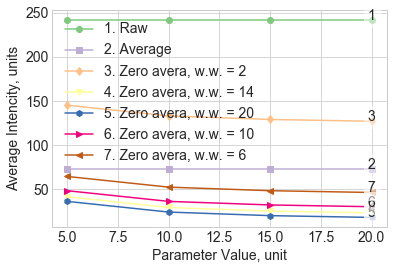

In [40]:
mpl.rcParams.update({'font.size': 14})

for f in data_base_max:
# Create structure for plot
    print f
    spec_aver_int = np.mean(baseline_spec_type[f])
    spec_aver_len = len(baseline_spec_type[f])
    sver_filter_int = np.mean(baseline_spec_type[f][baseline_spec_type[f] < np.mean(baseline_spec_type[f])])
    sver_filter_len = len(baseline_spec_type[f][baseline_spec_type[f] < np.mean(baseline_spec_type[f])])

    counter = 3
    metrik_data_max = [[spec_aver_int]*4, [sver_filter_int]*4]
    x_data = [range(5,21,5), range(5,21,5)]
    metrik_data_len = [[spec_aver_len]*4, [sver_filter_len]*4]
    metrik_name = [u'1. Raw', u'2. Average']
    for a in data_base_max[f]:
        if a in [2,3]:
            temp_d_max = []
            temp_d_len = []
            temp_x = []
            for p2 in data_base_max[f][a]['no']:
                temp_d_max.append(data_base_max[f][a]['no'][p2])
                temp_d_len.append(data_base_len[f][a]['no'][p2])
                temp_x.append(p2)
            _, temp_d_max = (list(x) for x in zip(*sorted(zip(temp_x, temp_d_max), key=lambda pair: pair[0])))
            temp_x, temp_d_len = (list(x) for x in zip(*sorted(zip(temp_x, temp_d_len), key=lambda pair: pair[0])))
            metrik_data_max.append(temp_d_max)
            metrik_data_len.append(temp_d_len)
            x_data.append(temp_x)
            if a == 2:
                metrik_name.append(str(counter) + u'. Average Windows')
            else:
                metrik_name.append(str(counter) + u'. Parabola')
            counter += 1
        else:
            for p1 in data_base_max[f][a]:
                temp_d_max = []
                temp_d_len = []
                temp_x = []
                for p2 in data_base_max[f][a][p1]:
                    temp_d_max.append(data_base_max[f][a][p1][p2])
                    temp_d_len.append(data_base_len[f][a][p1][p2])
                    temp_x.append(p2)
                _, temp_d_max = (list(x) for x in zip(*sorted(zip(temp_x, temp_d_max), key=lambda pair: pair[0])))
                temp_x, temp_d_len = (list(x) for x in zip(*sorted(zip(temp_x, temp_d_len), key=lambda pair: pair[0])))
                metrik_data_max.append(temp_d_max)
                metrik_data_len.append(temp_d_len)
                x_data.append(temp_x)
                metrik_name.append(str(counter) + u'. Zero avera, w.w. = ' + str(p1))
                counter += 1

    fig, ax1 = plt.subplots()

    for i in xrange(len(metrik_data_max)):
        if metrik_name[i].split('.')[0] not in ['8','9']:
            y = metrik_data_max[i]
            x = x_data[i]
            ax1.plot(x, y, markers_line[i], label=metrik_name[i], c=colors[i])
            ax1.text(x[-1], y[-1], metrik_name[i].split('.')[0],
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    ax1.set_xlabel(u'Parameter Value, unit')
    ax1.set_ylabel(u'Average Intencity, units')
    ax1.legend(loc='upper left')
    plt.draw()
    plt.savefig(f+'_spec_baseline_max_eng.png', dpi=300)
    plt.show()

In [23]:
# Расчет параметров пиков
# Find of base line
test_df = spe_df[spe_df.fraction == 'grain']
ftype_all = Counter(test_df.ftype)

base_type = {
    1:[xrange(0,11,2), xrange(5,26,5)],  # iteration of smooth, threshold
    2:xrange(0,27,2)  # iteration of smooth
    }
data_peaks_num = {}

for ftype in ftype_all.keys():
    # minimaise delta with average spectra for each type
    test_df2 = test_df[test_df.ftype == ftype]
    spec_all = test_df2.intence
    data_peaks_num[ftype] = {}
    # find baseline
    for t in base_type.keys():
        print ftype, 'baseline type: ', t, 
        data_peaks_num[ftype][t] = {}
        if t != 1:
            data_peaks_num[ftype][t]['no'] = {}
            for p in base_type[t]:
                s = []
                for spec_i in test_df2.intence:
                    auto_find = zero_area(spec_i, params=[10,10], type_alg=1)
                    mask_spec = is_baseline(auto_find) # floor=np.average(auto_find[1:]))
                    find_peak = calc_peacs(
                        spec_i, 
                        baseline_mask=mask_spec, 
                        base_fit=calc_baseline(spec_i, mask_spec), 
                        parameters=[p], 
                        type_calc=t
                    )[0]
                    s.append(len(find_peak))
                data_peaks_num[ftype][t]['no'][p] = np.average(s)
        else:
            for p in base_type[t][0]:
                print p,
                data_peaks_num[ftype][t][p]={}
                for p2 in base_type[t][1]:
                    print ' -', p2,
                    s = []
                    for spec_i in test_df2.intence:
                        auto_find = zero_area(spec_i, params=[10,10], type_alg=1)
                        mask_spec = is_baseline(auto_find) # floor=np.average(auto_find[1:]))
                        find_peak = calc_peacs(
                            spec_i, 
                            baseline_mask=mask_spec, 
                            base_fit=calc_baseline(spec_i, mask_spec), 
                            parameters=[p, p2], 
                            type_calc=t
                        )[0]
                        s.append(len(find_peak))
                    data_peaks_num[ftype][t][p][p2]=np.average(s)
                print ' +'
        print 'done'
print 'All Done'

npks baseline type:  1 0  - 5

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  - 10  - 15  - 20  - 25  +
2  - 5  - 10  - 15  - 20  - 25  +
4  - 5  - 10  - 15  - 20  - 25  +
6  - 5  - 10  - 15  - 20  - 25  +
8  - 5  - 10  - 15  - 20  - 25  +
10  - 5  - 10  - 15  - 20  - 25  +
done
npks baseline type:  2 done
All Done


npks


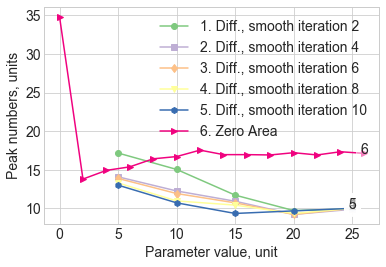

In [39]:
mpl.rcParams.update({'font.size': 14})

for f in data_peaks_num:
# Create structure for plot
    print f
    counter = 1
    x_data = []
    metrik_data = []
    metrik_name = []
    for a in data_peaks_num[f]:
        if a != 1:  # zero-area
            temp_d = []
            temp_x = []
            for p2 in data_peaks_num[f][a]['no']:
                temp_d.append(data_peaks_num[f][a]['no'][p2])
                temp_x.append(p2)
            temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
            metrik_data.append(temp_d)
            x_data.append(temp_x)
            metrik_name.append(str(counter) + u'. Zero Area')
            counter += 1
        else:
            for p1 in data_peaks_num[f][a]:
                if max(data_peaks_num[f][a][p1].values()) < 70:
                    temp_d = []
                    temp_x = []
                    for p2 in data_peaks_num[f][a][p1]:
                        temp_d.append(data_peaks_num[f][a][p1][p2])
                        temp_x.append(p2)
                    temp_x, temp_d = (list(x) for x in zip(*sorted(zip(temp_x, temp_d), key=lambda pair: pair[0])))
                    metrik_data.append(temp_d)
                    x_data.append(temp_x)
                    metrik_name.append(str(counter) + u'. Diff., smooth iteration ' + str(p1))
                    counter += 1
                else:
                    pass

    fig, ax1 = plt.subplots()

    for i in xrange(len(metrik_data)):
        if metrik_name[i].split('.')[0] not in ['8','9']:
            y = metrik_data[i]
            x = x_data[i]
            ax1.plot(x, y, markers_line[i], label=metrik_name[i], c=colors[i])
            ax1.text(x[-1], y[-1], metrik_name[i].split('.')[0],
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    ax1.set_xlabel(u'Parameter value, unit')
    ax1.set_ylabel(u'Peak numbers, units')
    ax1.legend(loc='upper right')
    plt.draw()
    plt.savefig(f+'_spec_peaks_eng_v2.png', dpi=300)
    plt.show()

## Работа с оптимальнаями параметрами и сохранение данных

## Work with optimal parameters and save data

['NPK(S) 4.30.15.16 500.dry', 'NPK(S) 4.30.15.16 rawgrain', 'NPK(S) 4.30.15.16 100.dry', 'NPK(S) 4.30.15.16 100', 'NPK(S) 4.30.15.16 grain', 'NPK(S) 4.30.15.16 500']
['NPK(S) 4-30-15(16) granules', 'NPK(S) 4-30-15(16) pressed 100 mkm', 'NPK(S) 4-30-15(16) pressed 500 mkm', 'NPK(S) 4-30-15(16) pressed granules']


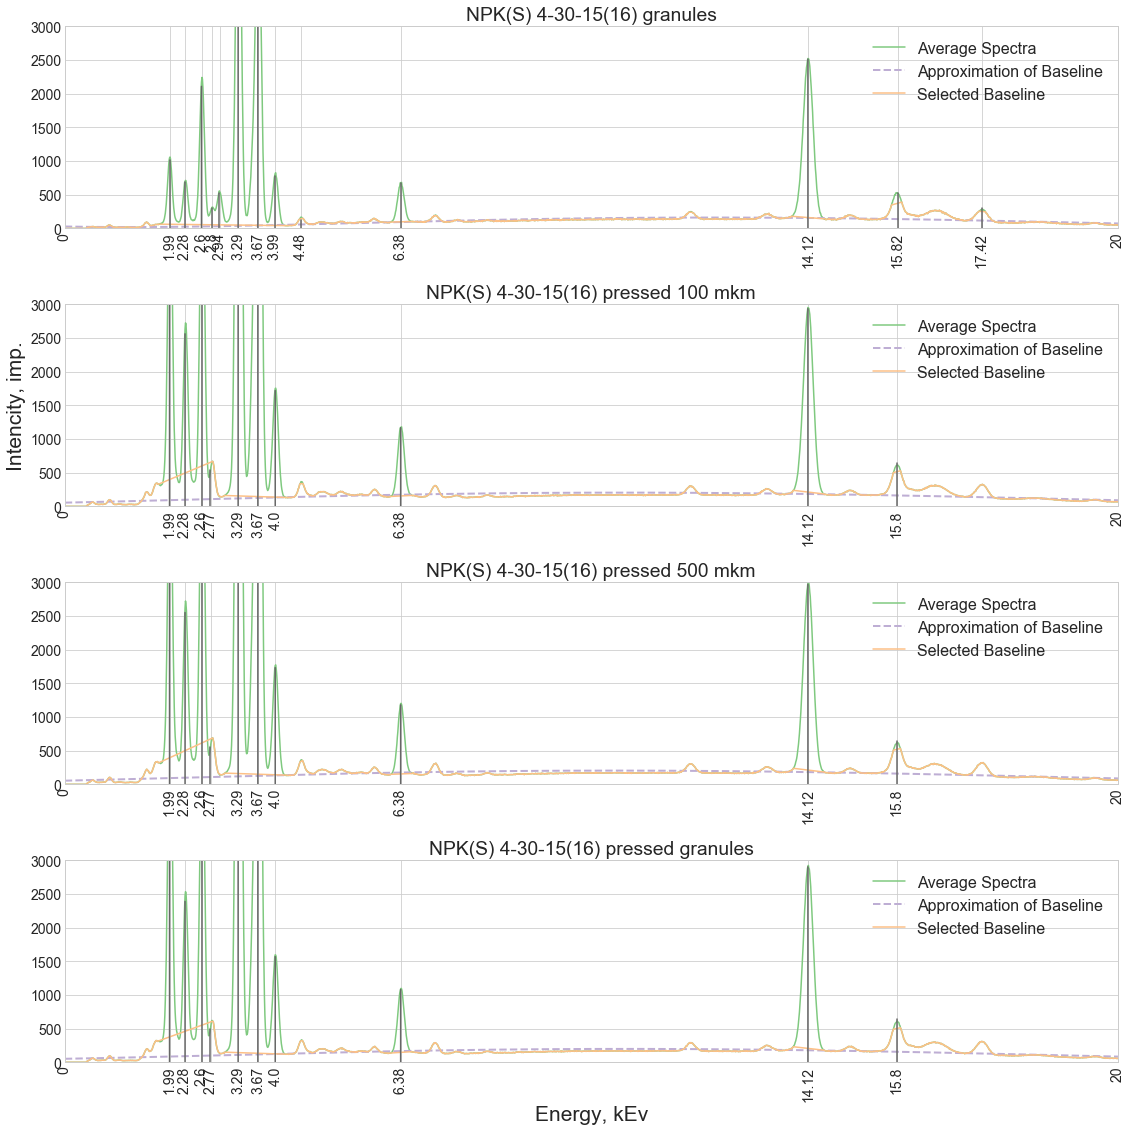

In [37]:
# Plot data for each type of probe: MAPh, MAPh_kd and NPKS_kd with average on each type with best parameters
mpl.rcParams.update({'font.size': 16})

spe_df_cl_type = spe_df.copy()
frac_types = list(spe_df_cl_type[spe_df_cl_type.ftype=='npks'].fraction)
intence = list(spe_df_cl_type[spe_df_cl_type.ftype=='npks'].intence)
marks = ['4.30.15.16']

specs = {}  # {type:[[intenses], [], ...]}
names = []
for i in xrange(len(frac_types)):
    type_obj = 'NPK(S) ' + str(marks[0]) + ' ' + str(frac_types[i])
    if type_obj in specs:
        specs[type_obj].append(intence[i])
    else:
        names.append(type_obj)
        specs[type_obj] = [intence[i]]

aver_specs = {}
for i in specs:
    aver_all = 0
    for j in specs[i]:
        aver_all = aver_all + np.array(j)
    aver_all = aver_all / float(len(specs[i]))
    aver_specs[i] = aver_all
    
print aver_specs.keys()


aver_specs.pop('NPK(S) 4.30.15.16 100.dry')
aver_specs.pop('NPK(S) 4.30.15.16 500.dry')

reverse_k = {
    'NPK(S) 4.30.15.16 rawgrain': 'NPK(S) 4-30-15(16) granules',
    'NPK(S) 4.30.15.16 grain': 'NPK(S) 4-30-15(16) pressed granules',
    'NPK(S) 4.30.15.16 500': 'NPK(S) 4-30-15(16) pressed 500 mkm',
    'NPK(S) 4.30.15.16 100': 'NPK(S) 4-30-15(16) pressed 100 mkm'
}
aver_specs = dict((reverse_k[key], value) for (key, value) in aver_specs.items())

    
c = np.arange(len(aver_specs['NPK(S) 4-30-15(16) granules']))
energy = np.average(spe_df_cl_type['a0']) + np.average(spe_df_cl_type['a1'])*c + np.average(spe_df_cl_type['a2'])*c*c

num_plot = len(aver_specs.keys())

fig, ax = plt.subplots(num_plot, figsize=(num_plot*4,num_plot*4))
names_all = list(aver_specs.keys())
print aver_specs.keys() 

gauss_h = {}
gauss_s = {}
for i in range(num_plot):
    name = names_all[i]
    gauss_h[i] = []
    gauss_s[i] = []
    spec = aver_specs[name]
    ax[i].plot(energy, spec, label = u'Average Spectra')
    
    auto_find = zero_area(spec, params=[14,10], type_alg=1)
    mask_spec = is_baseline(auto_find)  # floor=np.average(auto_find[1:]))
    fit_baseline = calc_baseline(spec_i=spec, baseline_mask=mask_spec)
    ax[i].plot(energy, fit_baseline, '--', label = u'Approximation of Baseline', linewidth=2)
    ax[i].plot(energy[mask_spec], spec[mask_spec], label = u'Selected Baseline')
    my_xticks = [0]
    
    find_peak = calc_peacs(spec, baseline_mask=mask_spec, base_fit=fit_baseline, parameters=[3,11,4], type_calc=2)
    for j in range(len(find_peak[1])):
        if find_peak[1][j] < 2500:
            c = find_peak[1][j]
            f_e = spe_df['a0'][0] + spe_df['a1'][0]*c + spe_df['a2'][0]*c*c
            if (round(f_e, 1) not in my_xticks) and (find_peak[0][j] > 2 * find_peak[-1][j]):
                my_xticks.append(round(f_e, 2))
                gauss_h[i].append(find_peak[2][j])
                gauss_s[i].append(find_peak[3][j])
                ax[i].plot([f_e for x in range(int(find_peak[0][j]))], 
                           [x for x in range(int(find_peak[0][j]))], c=colors[-1])
                
    ax[i].set_xlim((0, 20))
    ax[i].set_ylim((0, 3000))
    ax[i].set_title(names_all[i])
    ax[i].legend(loc = "upper right")
    my_xticks.append(20)
    ax[i].set_xticks(my_xticks)
    ax[i].set_xticklabels(my_xticks, rotation='vertical', fontsize=14)

ax[-1].set_xlabel(u'Energy, kEv', size=21)
ax[1].set_ylabel(u'Intencity, imp.', size=21)
    
plt.tight_layout()
plt.draw()
plt.savefig('aver_spec_npks_fract.png', dpi=300)
plt.show()

## Prepare all spectra with select algorithm

In [31]:
names = spe_df_cl_type.index.tolist()
spe_df_cl_type.loc[:, 'peaks_int']=None
spe_df_cl_type.loc[:, 'peaks_chan'] = None
spe_df_cl_type.loc[:, 'gauss_int'] = None
spe_df_cl_type.loc[:, 'gauss_square'] = None
spe_df_cl_type.loc[:, 'base_peaks_int'] = None
spe_df_cl_type.loc[:, 'base_s'] = None
spe_df_cl_type.loc[:, 'base_max_int'] = None
spe_df_cl_type.loc[:, 'base_max_chan'] = None
print 'all data: ', len(names)
    

for j in xrange(len(names)):
    i = names[j]
    spec = spe_df_cl_type.intence[i]
    print j, '. ', i, ' start... ',
    spec = smooth(spec_i=spec, params=[4, 15], type_smooth=2)
    auto_find = zero_area(spec, params=[10,10], type_alg=1)
    mask_spec = is_baseline(auto_find) #floor=np.average(auto_find[1:]))
    fit_baseline = calc_baseline(spec_i=spec, baseline_mask=mask_spec)
    all_peaks_int = []
    all_peaks_chan = []
    all_peak_g_h = []
    all_peak_g_s = []
    all_peak_b = []
    find_peak = calc_peacs(spec, baseline_mask=mask_spec, base_fit=fit_baseline, parameters=[3,11,4], type_calc=2)
    for j in xrange(len(find_peak[1])):
        if find_peak[1][j] < 2500 and find_peak[1][j] > 2.*find_peak[-1][j]:
            all_peaks_int.append(find_peak[0][j])
            all_peaks_chan.append(int(find_peak[1][j]))
            all_peak_g_h.append(find_peak[2][j])
            all_peak_g_s.append(find_peak[3][j])
            all_peak_b.append(find_peak[4][j])
    
    spe_df_cl_type.set_value(i, 'peaks_int', all_peaks_int)
    spe_df_cl_type.set_value(i, 'peaks_chan', all_peaks_chan)
    
    spe_df_cl_type.set_value(i, 'gauss_int', all_peak_g_h)
    spe_df_cl_type.set_value(i, 'gauss_square', all_peak_g_s)
    spe_df_cl_type.set_value(i, 'base_peaks_int', all_peak_b)
    
    spe_df_cl_type.set_value(i, 'base_s', np.sum(fit_baseline[0:2500]))
    
    base_max = np.max(fit_baseline[0:2500])
    spe_df_cl_type.set_value(i, 'base_max_int', base_max)
    print 'done'
print 'All Done'

all data:  118
0 .  0  start... 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel_l

 done
1 .  1  start...  done
2 .  2  start...  done
3 .  3  start...  done
4 .  4  start...  done
5 .  5  start...  done
6 .  6  start...  done
7 .  7  start...  done
8 .  8  start...  done
9 .  9  start...  done
10 .  10  start...  done
11 .  11  start...  done
12 .  12  start...  done
13 .  13  start...  done
14 .  14  start...  done
15 .  15  start...  done
16 .  16  start...  done
17 .  17  start...  done
18 .  18  start...  done
19 .  19  start...  done
20 .  20  start...  done
21 .  21  start...  done
22 .  22  start...  done
23 .  23  start...  done
24 .  24  start...  done
25 .  25  start...  done
26 .  26  start...  done
27 .  27  start...  done
28 .  28  start...  done
29 .  29  start...  done
30 .  30  start...  done
31 .  31  start...  done
32 .  32  start...  done
33 .  33  start...  done
34 .  34  start...  done
35 .  35  start...  done
36 .  36  start...  done
37 .  37  start...  done
38 .  38  start...  done
39 .  39  start...  done
40 .  40  start...  done
41 .  41  st

In [32]:
# Create elements columns and calculate characteristics line in X-ray spectrum

target_peaks = {
    1.7: 'Si',
    2.0: 'P',
    2.3: 'S',
    2.6: 'Cl',
    3.3: 'K',
    3.7: 'Ca',
    4.5: 'Ti',
    5.9: 'Mn',
    6.4: 'Fe',
    8.1: 'Ta',
    8.6: 'Zn',
    14.2: 'Sr',
    17.4: 'Mo',
    16.5: 'Mo_Coh'
}

ind = spe_df_cl_type.index.tolist()
col_name = target_peaks.keys()

# construct data {col_name: index_value}
data_all = {}
for e in target_peaks:
    data_all[e] = []
    for i in ind:
        c = int((e - spe_df_cl_type['a0'][i])/spe_df_cl_type['a1'][i])
        d = np.average(spe_df_cl_type['intence'][i][c-1:c+1])
        data_all[e].append(d)


spe_df2 = pd.DataFrame(columns=col_name, index=ind, data=data_all)  # df with channel columns


# energy list (equal of channel list) for each index
energy_all = pd.DataFrame(index=ind, data={'energy':[np.average(spe_df_cl_type['a0']) + \
            np.average(spe_df_cl_type['a1'])*np.array(x) + \
            np.average(spe_df_cl_type['a2'])*np.array(x)*np.array(x) for x in spe_df_cl_type.peaks_chan]})

for i in xrange(len(ind)):  # for all index in df
    i_ind = ind[i]  # df index
    data_en = energy_all['energy'][i_ind]
    for en_ind in xrange(len(data_en)):  # for each energy in energy list
        en = round(data_en[en_ind], 1)
        if en in col_name:  # if energy of finding peaks in list of peaks
            spe_df2[en][i_ind] = spe_df_cl_type['peaks_int'][i_ind][en_ind]

new_names_round = [target_peaks[x] for x in spe_df2.columns.tolist()]
spe_df2.columns = new_names_round
print spe_df2.head()


# Gauss int
ind = spe_df_cl_type.index.tolist()
col_name = target_peaks.keys()

def gauss_peaks2(i_all, channel_all, spec_i):
    # calculate Gauss S and I of peaks
    gauss_s = []
    gauss_i = []
    for i in xrange(len(channel_all)):
        c_middle = channel_all[i]
        g_h = 0
        g_s = 0
        w = 15
        y = np.array(spec_i[c_middle-w:c_middle+w])  # gauss fit of points
        x = np.array(xrange(len(y)))
        # correction for weighted arithmetic mean
        mean = np.sum(x * y) / np.sum(y)
        sigma = np.sqrt(np.sum(y * (x - mean)**2) / np.sum(y))
        try:
            popt,pcov = curve_fit(gaus, x, y, p0=[max(y), mean, sigma])
            y_fit = gaus(x, *popt)
            g_h = np.max(y_fit)
            g_s = g_h * (2 * np.pi) ** 0.5 * popt[-1]  # gauss square
        except RuntimeError as var:
            g_h = 0
            g_s = 0
        except ValueError as var:
            print var
            print x, y
            g_h = 0
            g_s = 0
        gauss_i.append(g_h)
        gauss_s.append(g_s)
    return np.array(gauss_i), np.array(gauss_s)

# construct data {col_name: index_value} with calculate value from raw spectra
data_all = {}
data_all2 = {}
for e in target_peaks:
    data_all[e] = []
    data_all2[e] = []
    
    for i in ind: 
        c = int((e - spe_df_cl_type['a0'][i])/spe_df_cl_type['a1'][i])
        spec = spe_df_cl_type['intence'][i]
        d = gauss_peaks2([spec[c]], [c], spec)
        data_all[e].append(d[0][0])
        data_all2[e].append(d[1][0])


spe_df3 = pd.DataFrame(columns=col_name, index=ind, data=data_all)  # df with channel columns
spe_df4 = pd.DataFrame(columns=col_name, index=ind, data=data_all2)  # df with channel columns

energy_all = pd.DataFrame(index=ind, data={'energy':[np.average(spe_df_cl_type['a0']) + \
            np.average(spe_df_cl_type['a1'])*np.array(x) + \
            np.average(spe_df_cl_type['a2'])*np.array(x)*np.array(x) for x in spe_df_cl_type.peaks_chan]})

for i in xrange(len(ind)):  # for all index in df
    i_ind = ind[i]  # df index
    data_en = energy_all['energy'][i_ind]
    for en_ind in xrange(len(data_en)):  # for each energy in energy list
        en = round(data_en[en_ind], 1)
        if en in col_name:
            spe_df3[en][i_ind] = spe_df_cl_type['gauss_int'][i_ind][en_ind]

new_names_round = ['Gauss.int_' + target_peaks[x] for x in spe_df3.columns.tolist()]
spe_df3.columns = new_names_round
# spe_df3 = spe_df3.loc[:,~spe_df3.columns.duplicated()]

print spe_df3.head()


# Gauss square
for i in xrange(len(ind)):  # for all index in df
    i_ind = ind[i]  # df index
    data_en = energy_all['energy'][i_ind]
    for en_ind in xrange(len(data_en)):  # for each energy in energy list
        en = round(data_en[en_ind], 1)
        if en in col_name:
            spe_df4[en][i_ind] = spe_df_cl_type['gauss_square'][i_ind][en_ind]

new_names_round = ['Gauss.sqe_' + target_peaks[x] for x in spe_df4.columns.tolist()]
spe_df4.columns = new_names_round
# spe_df3 = spe_df3.loc[:,~spe_df3.columns.duplicated()]

print spe_df4.head()


# Concatenate
_spe_backup = spe_df_cl_type.copy()
spe_df_cl_type = pd.concat([spe_df_cl_type, spe_df2], axis=1)
spe_df_cl_type = pd.concat([spe_df_cl_type, spe_df3], axis=1)
spe_df_cl_type = pd.concat([spe_df_cl_type, spe_df4], axis=1)

print spe_df_cl_type.shape
spe_df_cl_type = spe_df_cl_type.loc[:,~spe_df_cl_type.columns.duplicated()]
print spe_df_cl_type.shape

           Ti  Mo_Coh            P    Si     Ta     Zn          Fe  \
0  129.384529   272.0  1006.501009  44.0  111.0  101.0  619.249155   
1  137.037628   247.5   995.017825  46.0  122.0  105.0  637.019248   
2  111.441463   262.0   905.664878  40.0  104.0  109.5  591.678159   
3  182.964675   274.5  1040.881217  52.5  120.5  101.5  747.982530   
4  143.055810   287.0  1094.369807  49.0  118.0  117.5  730.648810   

            S            K          Mo      Sr           Ca     Mn  \
0  671.294053  6031.282690  282.513319  1835.0  4922.477767  140.5   
1  649.770450  5944.970328  304.820598  1811.0  4732.075199  119.5   
2  677.128804  6254.167335  277.907663  1803.0  4785.358494  110.0   
3  734.601407  6654.539539  315.945697  2057.5  5476.197952  158.0   
4  758.327250  6515.351330  300.213075  2077.0  5635.215976  146.0   

            Cl  
0  1940.049791  
1  2056.749509  
2  2323.368930  
3  2168.094544  
4  2001.890261  
   Gauss.int_Ti  Gauss.int_Mo_Coh  Gauss.int_P  Gauss.in

In [ ]:
spe_df_cl_type.to_pickle('spe_df_cl_type')  # save data frame